In [1]:
import autograd.numpy as anp
from autograd import value_and_grad, grad

In [2]:
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.numpy.linalg import solve

In [3]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_is_fitted

In [4]:
from scipy.optimize import check_grad, minimize

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
eps = 1e-8

def logdet(X):
    sign, logdet = np.linalg.slogdet(X)
    return logdet

def rbf_covariance(kernel_params, x, xp=None):
    _xp = x if xp is None else xp
    output_scale = (kernel_params[0])**2 #parametrization
    lengthscales = (kernel_params[1:])**2 #parametrization
    diffs = anp.expand_dims(x /lengthscales, 1) - anp.expand_dims(_xp/lengthscales, 0)
    rbf = output_scale * anp.exp(-0.5 * anp.sum(diffs**2, axis=2))
    return (rbf + eps * anp.eye(x.shape[0])) if xp is None else rbf # for numerical stability

def unpack_kernel_params(params):
    params = params.flatten()
    mean        = params[0]
    cov_params  = params[2:]
    noise_scale = (params[1])**2 + 1e-4 #parametrization
    return mean, cov_params, noise_scale

In [7]:
# Gaussian Process regression
class sparseGPR(BaseEstimator):
    def __init__(self, cov_func):
        self.cov_func = cov_func
 
    def _check_is_fitted(self):
        check_is_fitted(self, ['mean', 'kernel_params', 'noise_scale'])

    def _predict_sparse_exact(self, xstar):
        
        M = self.M

        mean, kernel_params, noise_scale = self.mean, self.kernel_params, self.noise_scale

        Kmm = self.cov_func(kernel_params, self.Z, self.Z) 
        Knm = self.cov_func(kernel_params, xstar, self.Z) 

        #KmmInv = anp.linalg.inv(Kmm)
        #A = anp.dot(Knm, KmmInv) # NxM solve(Kmm, Knm.T).T
        A = solve(Kmm, Knm.T).T

        # optimal mu, C 
        # [Titsias] (17) in http://www.aueb.gr/users/mtitsias/papers/sparseGPv2.pdf
        # [Bui] (25) http://mlg.eng.cam.ac.uk/thang/docs/talks/rcc_vargp.pdf
        Knm_ = self.cov_func(kernel_params, self.X, self.Z) 
        Sigma = Kmm + 1./noise_scale*anp.dot(Knm_.T, Knm_)
        KmmSigmaInv = solve(Sigma, Kmm).T
        mu = 1./noise_scale*anp.dot(anp.dot(KmmSigmaInv, Knm_.T), self.Y)
        C = anp.dot(KmmSigmaInv, Kmm)

        AC = anp.dot(A, C)

        pred_mean = mean +  anp.dot(A, mu)
        pred_cov = self.cov_func(kernel_params, xstar, xstar) - anp.dot(A, Knm.T) + anp.dot(AC, A.T) + noise_scale * anp.eye(xstar.shape[0])

        return pred_mean.flatten(), pred_cov
    
    # predictive distribution
    # [Titsias] (8) http://www.aueb.gr/users/mtitsias/papers/sparseGPv2.pdf
    def predict(self, xstar):
        
        self._check_is_fitted()
        
        mean, cov = self._predict_sparse_exact(xstar)
        return mean, cov


    # optimal lower bound 
    #[Titsias] (16) http://www.aueb.gr/users/mtitsias/papers/sparseGPv2.pdf
    #[Bui] (26) http://mlg.eng.cam.ac.uk/thang/docs/talks/rcc_vargp.pdf
    def _neg_lower_bound_exact(self, hyperparams):

        N = self.N
        M = self.M

        mean, kernel_params, noise_scale = unpack_kernel_params(hyperparams)

        Kmm = self.cov_func(kernel_params, self.Z, self.Z) 
        #KmmInv = anp.linalg.inv(Kmm)
        Knm_ = self.cov_func(kernel_params, self.X, self.Z) 
        Knn_ = self.cov_func(kernel_params, self.X, self.X) # precompute
        #Qnn = anp.dot(anp.dot(Knm_,KmmInv),Knm_.T)
        Qnn = anp.dot(solve(Kmm, Knm_.T).T, Knm_.T)

        LL = mvn.logpdf(self.Y, mean + anp.zeros(self.Y.shape), noise_scale*anp.eye(N) + Qnn) - 0.5/noise_scale*( anp.trace(Knn_) - anp.trace(Qnn) )

        return -LL
 
        
    def fit(self, x, y, z):       
        
        self.X = x
        self.Y = y
        self.Z = z
        self.M = z.shape[0]
        self.N = y.shape[0]
        self.dim = x.shape[1]
               
        init_params = np.random.rand(3+self.dim,)
        optimized_params = minimize(value_and_grad(lambda p: self._neg_lower_bound_exact(p)), init_params, jac=True, method='CG').x
        
        mean, kernel_params, noise_scale = unpack_kernel_params(optimized_params)
        self.mean = mean
        self.kernel_params = kernel_params
        self.noise_scale = noise_scale
        

In [8]:
def build_toy_dataset(D=1, n_data=20, noise_std=0.1):
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(0, 3, num=n_data/2), np.linspace(6, 8, num=n_data/2)])
    targets = (np.cos(inputs) + rs.randn(n_data) * noise_std) / 2.0
    inputs = (inputs - 4.0) / 2.0
    inputs  = inputs.reshape((len(inputs), D))
    return inputs, targets

In [9]:
dim = 1
X, y = build_toy_dataset(D=dim, n_data=100, noise_std=0.1)

# number of inducing inputs
M = 10

# inducing inputs
# (default): run k-means on training set
#kmeans = KMeans(n_clusters=M, random_state=0).fit(X)
#Z = kmeans.cluster_centers_.reshape(M,dim)

Z = np.linspace(-3, 3, M).reshape(M,dim)

gp = sparseGPR(rbf_covariance)
gp.fit(X, y, Z)


/home/alexey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


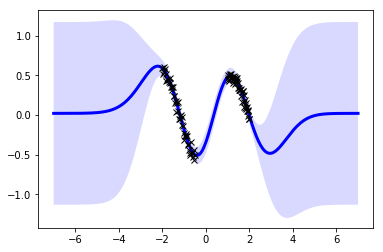

In [10]:
# Show posterior marginals.
plot_xs = np.reshape(np.linspace(-7, 7, 300), (300,1))
pred_mean, pred_cov = gp.predict(plot_xs)

marg_std = np.sqrt(np.diag(pred_cov)) # take diagonal

plt.plot(plot_xs, pred_mean, 'b', linewidth=3.0)
plt.fill(np.concatenate([plot_xs, plot_xs[::-1]]), np.concatenate([pred_mean - 1.96 * marg_std, (pred_mean + 1.96 * marg_std)[::-1]]), alpha=.15, fc='Blue', ec='None')

# Show samples from posterior.
#rs = npr.RandomState(0)
#sampled_funcs = rs.multivariate_normal(pred_mean, pred_cov, size=2)
#ax.plot(plot_xs, sampled_funcs.T)

plt.plot(X, y, 'kx')
plt.show()
